### Mohammad Sepehr Bazargan
##### 810102303
##### Imports

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [62]:
df = pd.read_csv('Grades.csv')
print(df.shape)
print(df.info())
print(df.head())

(397, 25)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   university         397 non-null    object
 1   sex                397 non-null    object
 2   age                397 non-null    int64 
 3   address            397 non-null    object
 4   motherEducation    397 non-null    int64 
 5   fatherEducation    397 non-null    int64 
 6   motherJob          397 non-null    object
 7   fatherJob          397 non-null    object
 8   reason             397 non-null    object
 9   travelTime         397 non-null    int64 
 10  studyTime          397 non-null    int64 
 11  failures           397 non-null    int64 
 12  universitySupport  397 non-null    object
 13  paid               397 non-null    object
 14  higher             397 non-null    object
 15  internet           397 non-null    object
 16  romantic           397 non-null   

#### df.isnull() returns 0 for all the columns so we don't have any missing data.

In [63]:
print(df.isnull().sum())
print ("missing rows :")
missing_rows = df[df.isnull().any(axis=1)]
print(missing_rows)

university           0
sex                  0
age                  0
address              0
motherEducation      0
fatherEducation      0
motherJob            0
fatherJob            0
reason               0
travelTime           0
studyTime            0
failures             0
universitySupport    0
paid                 0
higher               0
internet             0
romantic             0
freeTime             0
goOut                0
Dalc                 0
Walc                 0
absences             0
EPSGrade             0
DSGrade              0
finalGrade           0
dtype: int64
missing rows :
Empty DataFrame
Columns: [university, sex, age, address, motherEducation, fatherEducation, motherJob, fatherJob, reason, travelTime, studyTime, failures, universitySupport, paid, higher, internet, romantic, freeTime, goOut, Dalc, Walc, absences, EPSGrade, DSGrade, finalGrade]
Index: []

[0 rows x 25 columns]


### Potentialy dropping a row 
I didn't drop anything as I thought every data would uniquely be helpful , but later in the code i dropped one thing for the xgboost , and dropping some of the features that are not used by the decision tree at all might be helpful too. 

### Numerifying the data

##### Categorizing the final scores int 0,1,2,3 and 0 being the better one 

In [64]:
bins = [0, 10, 14, 17,20]
labels = [3, 2, 1, 0]
df['finalGrade_cat'] = pd.cut(df['finalGrade'], bins=bins, labels=labels, include_lowest=True)
df['EPSGrade_cat'] = pd.cut(df['EPSGrade'], bins=bins, labels=labels, include_lowest=True)
df['DSGrade_cat'] = pd.cut(df['DSGrade'], bins=bins, labels=labels, include_lowest=True)

print(df[['finalGrade', 'finalGrade_cat', 'EPSGrade', 'EPSGrade_cat', 'DSGrade', 'DSGrade_cat']].head())
df.drop('finalGrade', axis=1, inplace=True)
df.drop('EPSGrade', axis=1, inplace=True)
df.drop('DSGrade', axis=1, inplace=True)

   finalGrade finalGrade_cat  EPSGrade EPSGrade_cat  DSGrade DSGrade_cat
0           6              3         5            3        6           3
1           6              3         5            3        5           3
2          10              3         7            3        8           3
3          15              1        15            1       14           2
4          10              3         6            3       10           3


##### changing all the objects from string to one hot numbers.

In [65]:
categorical_cols = df.select_dtypes(include=['object']).columns

yes_no_cols = [col for col in categorical_cols if set(df[col].unique()) == {'yes', 'no'} or set(df[col].unique()) == {'no', 'yes'}]
for col in yes_no_cols:
    df[col] = df[col].map({'yes': 1, 'no': 0})

categorical_cols = df.select_dtypes(include=['object']).columns

df_encoded = pd.get_dummies(df, columns=categorical_cols)
df_encoded = df_encoded.astype(int)
print(df_encoded.head())
print(df_encoded.columns)
print(df.columns)

df_encoded.to_csv('encoded_data.csv', index=False)
#print(y.value_counts())

   age  motherEducation  fatherEducation  travelTime  studyTime  failures  \
0   18                4                4           2          2         0   
1   17                1                1           1          2         0   
2   15                1                1           1          2         3   
3   15                4                2           1          3         0   
4   16                3                3           1          2         0   

   universitySupport  paid  higher  internet  ...  motherJob_teacher  \
0                  1     0       1         0  ...                  0   
1                  0     0       1         1  ...                  0   
2                  1     1       1         1  ...                  0   
3                  0     1       1         1  ...                  0   
4                  0     1       1         0  ...                  0   

   fatherJob_at_home  fatherJob_health  fatherJob_other  fatherJob_services  \
0                  0     

#### Train Test Split

In [66]:
X = df_encoded.drop(['finalGrade_cat'], axis=1)
y = df_encoded['finalGrade_cat']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (317, 38)
Test shape: (80, 38)


#### Normalization & Standardization

##### MinMax Scaling(Normalization)

In [67]:
def normalization(X):
    X_scaled = MinMaxScaler().fit_transform(X)
    return X_scaled

##### Z-score (Standardization)

In [68]:
def standardization(X):
    X_scaled = StandardScaler().fit_transform(X)
    return X_scaled

X_train_scaled = standardization(X_train)
X_test_scaled = standardization(X_test)
    

##### we will use standardization because our values are not bounded between [0,1] and can vary a lot since we have scores , ages , times , ... so standardization would fit better because it won't bound the data to specific values.

#### Naive Bayes

In [69]:
NB = GaussianNB()
NB.fit(X_train_scaled, y_train)

y_pred = NB.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.7375

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00        11
           2       0.57      0.89      0.70        27
           3       0.92      0.92      0.92        38

    accuracy                           0.74        80
   macro avg       0.37      0.45      0.40        80
weighted avg       0.63      0.74      0.67        80


Confusion Matrix:
 [[ 0  0  4  0]
 [ 0  0 11  0]
 [ 0  0 24  3]
 [ 0  0  3 35]]


##### according to the confusion matrix we are finding category 3 and 2 scores correctly but not finding any 1s or 0s , and we have >120 data of each of 3,2 groups and less than 50 for 0,1 so what we should do is Upsample the 0,1 :

In [70]:
train_data = pd.concat([X_train, y_train], axis=1)

df_0 = train_data[train_data['finalGrade_cat'] == 0]
df_1 = train_data[train_data['finalGrade_cat'] == 1]
df_2 = train_data[train_data['finalGrade_cat'] == 2]
df_3 = train_data[train_data['finalGrade_cat'] == 3]


df_0_upsampled = resample(df_0, replace=True, n_samples=len(df_3), random_state=42)
df_1_upsampled = resample(df_1, replace=True, n_samples=len(df_3), random_state=42)


train_balanced = pd.concat([df_0_upsampled, df_1_upsampled, df_2, df_3]) #concatenate what we just made and what we had.
train_balanced = train_balanced.sample(frac=1, random_state=42) #randomize the data again

X_train_balanced = train_balanced.drop('finalGrade_cat', axis=1)
y_train_balanced = train_balanced['finalGrade_cat']

X_train_balanced_scaled = standardization(X_train_balanced)


NB = GaussianNB()
NB.fit(X_train_balanced_scaled, y_train_balanced)

y_pred = NB.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.5125

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00        11
           2       0.41      0.96      0.57        27
           3       0.94      0.39      0.56        38

    accuracy                           0.51        80
   macro avg       0.34      0.34      0.28        80
weighted avg       0.58      0.51      0.46        80


Confusion Matrix:
 [[ 0  0  4  0]
 [ 0  0 11  0]
 [ 0  0 26  1]
 [ 0  0 23 15]]


##### I expected improvements but as we can see its worse, its because we have too little real data for 0,1 and now we have made lots of unreal data for them and now we have less data for 2,3 too so the accuracy of prediction of those classes will be lower too.

#### Decision Tree

In [71]:
#we use balanced class weight because of the imbalance that we have in our data.
dt = DecisionTreeClassifier(class_weight='balanced', random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("\nClassification Report:\n", classification_report(y_test, y_pred_dt, zero_division=0))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))

Accuracy: 0.8125

Classification Report:
               precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       0.90      0.82      0.86        11
           2       0.74      0.74      0.74        27
           3       0.84      0.84      0.84        38

    accuracy                           0.81        80
   macro avg       0.82      0.85      0.83        80
weighted avg       0.81      0.81      0.81        80


Confusion Matrix:
 [[ 4  0  0  0]
 [ 1  9  1  0]
 [ 0  1 20  6]
 [ 0  0  6 32]]


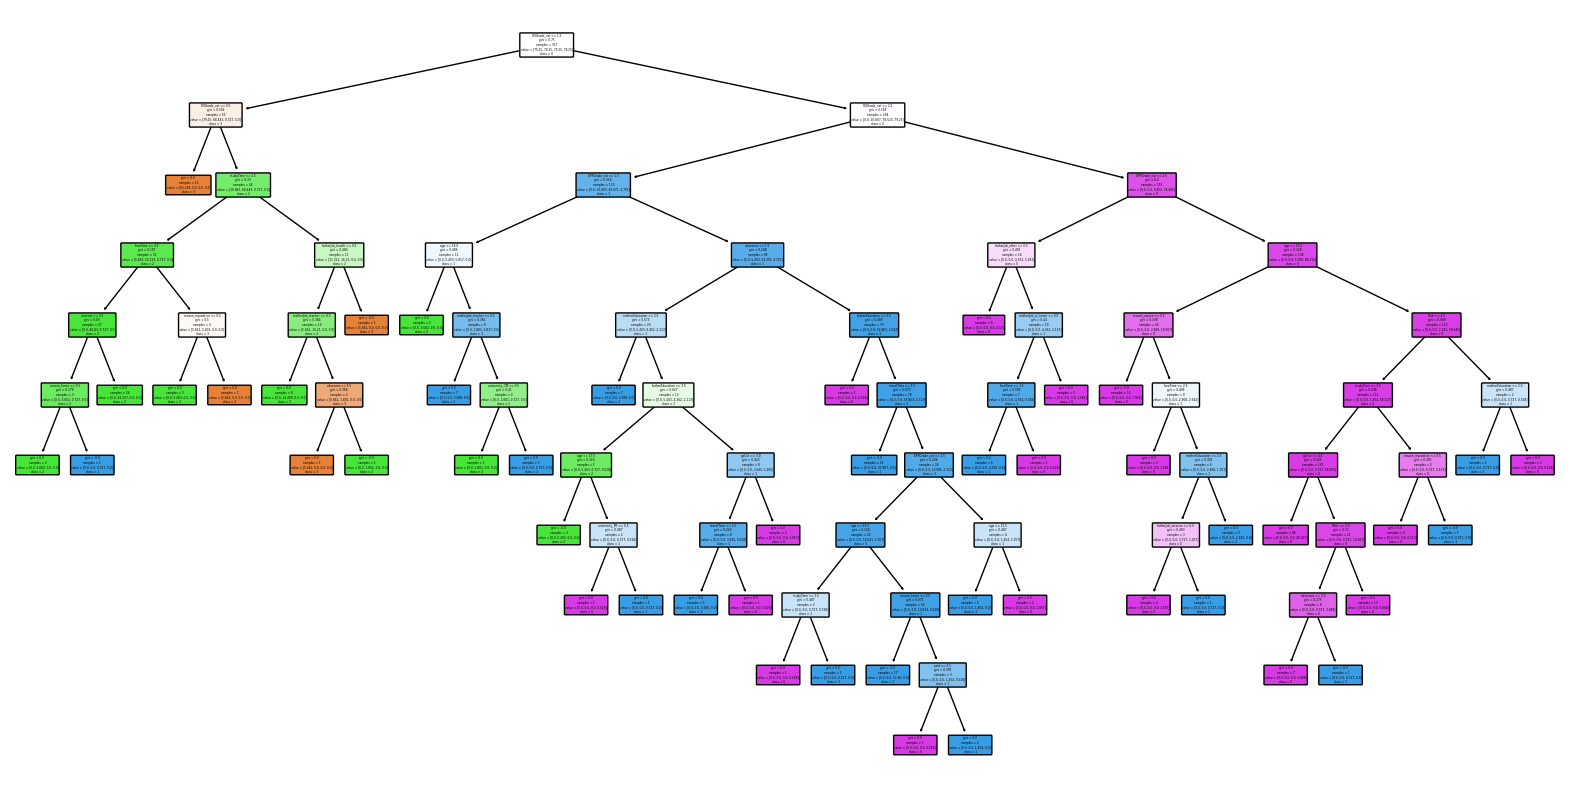

In [72]:
plt.figure(figsize=(20,10))
plot_tree(dt, feature_names=X_train.columns, class_names=['3','2','1','0'], filled=True, rounded=True)
plt.show()


Feature ranking:
1. DSGrade_cat: 0.6979
2. absences: 0.0311
3. motherJob_teacher: 0.0310
4. freeTime: 0.0283
5. age: 0.0281
6. reason_reputation: 0.0278
7. EPSGrade_cat: 0.0247
8. fatherJob_health: 0.0208
9. studyTime: 0.0189
10. fatherEducation: 0.0170
11. motherEducation: 0.0150
12. fatherJob_other: 0.0081
13. motherJob_at_home: 0.0080
14. reason_course: 0.0075
15. reason_home: 0.0061
16. goOut: 0.0057
17. travelTime: 0.0053
18. university_CM: 0.0044
19. fatherJob_services: 0.0036
20. paid: 0.0033
21. Dalc: 0.0032
22. university_PR: 0.0026
23. internet: 0.0009
24. Walc: 0.0006
25. motherJob_other: 0.0000
26. sex_F: 0.0000
27. address_R: 0.0000
28. romantic: 0.0000
29. reason_other: 0.0000
30. higher: 0.0000
31. motherJob_health: 0.0000
32. universitySupport: 0.0000
33. failures: 0.0000
34. motherJob_services: 0.0000
35. sex_M: 0.0000
36. fatherJob_teacher: 0.0000
37. fatherJob_at_home: 0.0000
38. address_U: 0.0000


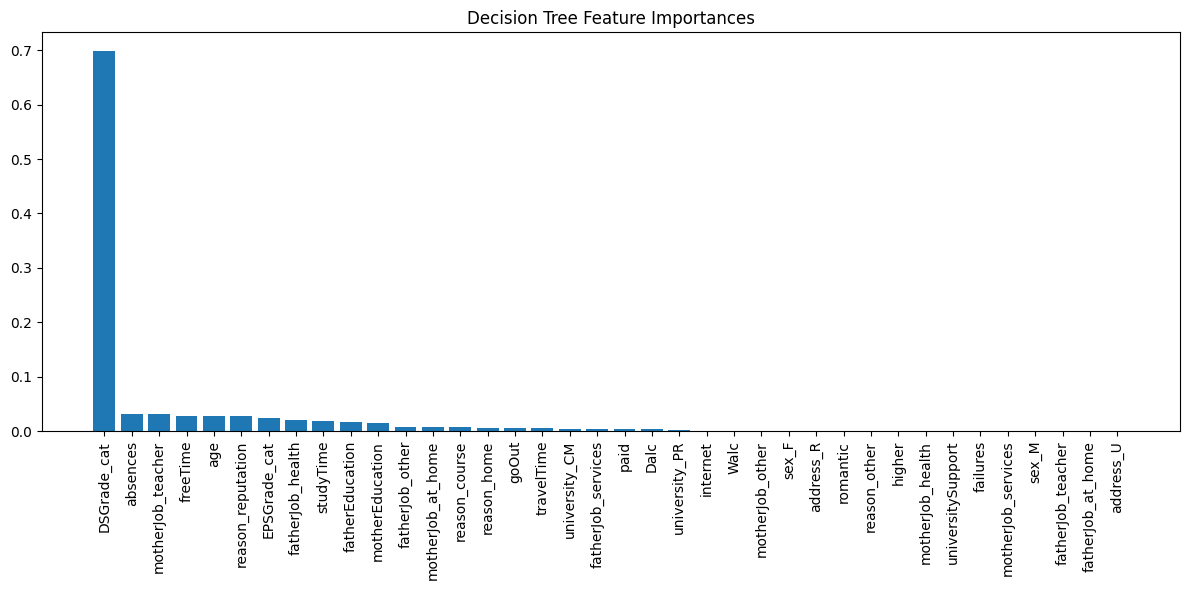

In [73]:
importances = dt.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
for i in range(len(indices)):
    print(f"{i+1}. {X_train.columns[indices[i]]}: {importances[indices[i]]:.4f}")

plt.figure(figsize=(12,6))
plt.title("Decision Tree Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.tight_layout()
plt.show()

##### predicted using max_depth=3 gives the best_value which is 93% , to check its not overfitting we predict the train data and it is 89% , since the difference is not too high we are not overfitting.

In [74]:
dt = DecisionTreeClassifier(class_weight='balanced', random_state=42, max_depth=3)
dt.fit(X_train, y_train)
y_pred_train_dt = dt.predict(X_train)
y_pred_dt = dt.predict(X_test)


print("Accuracy:", accuracy_score(y_train, y_pred_train_dt))
print("\nClassification Report:\n", classification_report(y_train, y_pred_train_dt, zero_division=0))
print("\nConfusion Matrix:\n", confusion_matrix(y_train, y_pred_train_dt))


print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("\nClassification Report:\n", classification_report(y_test, y_pred_dt, zero_division=0))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))

Accuracy: 0.8990536277602523

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.79      0.88        14
           1       0.90      0.86      0.88        44
           2       0.86      0.87      0.87       109
           3       0.92      0.94      0.93       150

    accuracy                           0.90       317
   macro avg       0.92      0.87      0.89       317
weighted avg       0.90      0.90      0.90       317


Confusion Matrix:
 [[ 11   3   0   0]
 [  0  38   6   0]
 [  0   1  95  13]
 [  0   0   9 141]]
Accuracy: 0.9375

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      0.91      0.95        11
           2       0.92      0.89      0.91        27
           3       0.93      0.97      0.95        38

    accuracy                           0.94        80
   macro avg       0.96      0.94      0.95   

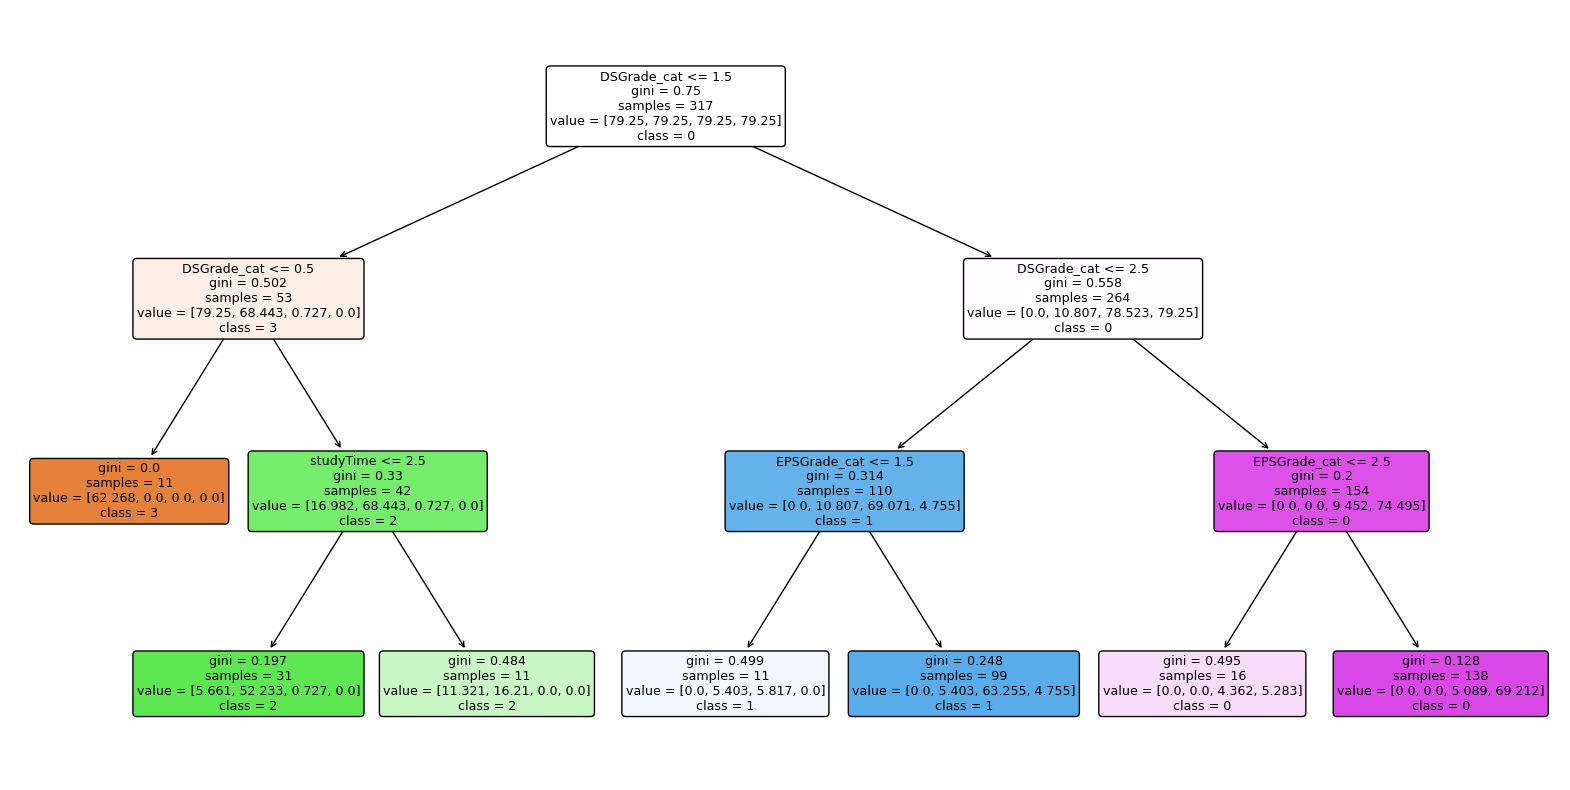

In [75]:
plt.figure(figsize=(20,10))
plot_tree(dt, feature_names=X_train.columns, class_names=['3','2','1','0'], filled=True, rounded=True)
plt.show()

Feature ranking:
1. DSGrade_cat: 0.9491
2. EPSGrade_cat: 0.0304
3. studyTime: 0.0204
4. internet: 0.0000
5. absences: 0.0000
6. Walc: 0.0000
7. Dalc: 0.0000
8. goOut: 0.0000
9. freeTime: 0.0000
10. romantic: 0.0000
11. reason_reputation: 0.0000
12. reason_other: 0.0000
13. paid: 0.0000
14. universitySupport: 0.0000
15. failures: 0.0000
16. travelTime: 0.0000
17. fatherEducation: 0.0000
18. motherEducation: 0.0000
19. higher: 0.0000
20. university_CM: 0.0000
21. university_PR: 0.0000
22. sex_F: 0.0000
23. reason_home: 0.0000
24. reason_course: 0.0000
25. fatherJob_teacher: 0.0000
26. fatherJob_services: 0.0000
27. fatherJob_other: 0.0000
28. fatherJob_health: 0.0000
29. fatherJob_at_home: 0.0000
30. motherJob_teacher: 0.0000
31. motherJob_services: 0.0000
32. motherJob_other: 0.0000
33. motherJob_health: 0.0000
34. motherJob_at_home: 0.0000
35. address_U: 0.0000
36. address_R: 0.0000
37. sex_M: 0.0000
38. age: 0.0000


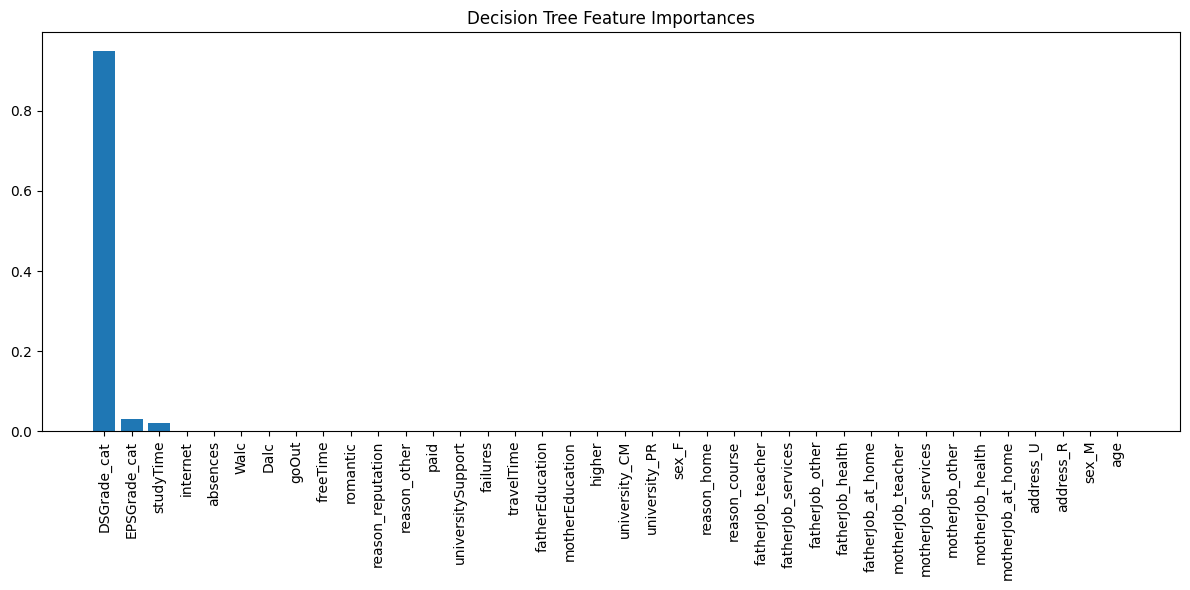

In [76]:
importances = dt.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
for i in range(len(indices)):
    print(f"{i+1}. {X_train.columns[indices[i]]}: {importances[indices[i]]:.4f}")

plt.figure(figsize=(12,6))
plt.title("Decision Tree Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.tight_layout()
plt.show()

##### In both trees (limited and unlimited) DSGrade is the top feature , after that we have som more features in the unlimited one but in the limited one we are almost using 1 feature and a little 2 others so it just decides on the most predictive feature and is simpler , but on more complex situations the unlimited tree would be better cause it uses the features until it has no more data so it will give opportunity to all the features.

#### Random Forest

In [77]:
rf = RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42, max_depth=3)
rf.fit(X_train, y_train)

y_pred_train_rf = rf.predict(X_train)
y_pred_rf = rf.predict(X_test)

print("Train Accuracy:", accuracy_score(y_train, y_pred_train_rf))
print("Test Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report (Test):\n", classification_report(y_test, y_pred_rf, zero_division=0))
print("\nConfusion Matrix (Test):\n", confusion_matrix(y_test, y_pred_rf))

Train Accuracy: 0.889589905362776
Test Accuracy: 0.875

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.73      0.84        11
           2       0.82      0.85      0.84        27
           3       0.90      0.92      0.91        38

    accuracy                           0.88        80
   macro avg       0.88      0.88      0.87        80
weighted avg       0.88      0.88      0.87        80


Confusion Matrix (Test):
 [[ 4  0  0  0]
 [ 1  8  2  0]
 [ 0  0 23  4]
 [ 0  0  3 35]]


In [78]:
param_dist = {
    'n_estimators': randint(50, 300),
    'max_depth': [3, 5, 7, None],
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 5),
}

rf = RandomForestClassifier(class_weight='balanced' , random_state=42)
random_search = RandomizedSearchCV(
    rf, param_distributions=param_dist, n_iter=20, cv=5, 
    scoring='accuracy', n_jobs=-1, random_state=42
)
random_search.fit(X_train, y_train)

print("Best parameters:", random_search.best_params_)
print("Best cross-validation accuracy:", random_search.best_score_)

best_rf = random_search.best_estimator_
y_pred_rf = best_rf.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report (Test):\n", classification_report(y_test, y_pred_rf, zero_division=0))
print("\nConfusion Matrix (Test):\n", confusion_matrix(y_test, y_pred_rf))

Best parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 285}
Best cross-validation accuracy: 0.8644345238095237
Test Accuracy: 0.9125

Classification Report (Test):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      0.91      0.95        11
           2       0.86      0.89      0.87        27
           3       0.92      0.92      0.92        38

    accuracy                           0.91        80
   macro avg       0.94      0.93      0.94        80
weighted avg       0.91      0.91      0.91        80


Confusion Matrix (Test):
 [[ 4  0  0  0]
 [ 0 10  1  0]
 [ 0  0 24  3]
 [ 0  0  3 35]]


#### XGBoost

In [79]:
df_encoded.drop('EPSGrade_cat', axis=1, inplace=True)

X = df_encoded.drop(['finalGrade_cat'], axis=1)
y = df_encoded['finalGrade_cat']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


##### without dropping this the accuracy would be 100% which means that the model is too strong and might have found data that it shouldn't in the provided train data meaning it could find a relation that it led to the right answer without actually predicting anything

In [80]:
xgb = XGBClassifier(objective='multi:softmax', num_class=4, random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("\nClassification Report (Test):\n", classification_report(y_test, y_pred_xgb, zero_division=0))
print("\nConfusion Matrix (Test):\n", confusion_matrix(y_test, y_pred_xgb))

Test Accuracy: 0.8625

Classification Report (Test):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      0.91      0.95        11
           2       0.79      0.81      0.80        27
           3       0.87      0.87      0.87        38

    accuracy                           0.86        80
   macro avg       0.91      0.90      0.91        80
weighted avg       0.87      0.86      0.86        80


Confusion Matrix (Test):
 [[ 4  0  0  0]
 [ 0 10  1  0]
 [ 0  0 22  5]
 [ 0  0  5 33]]


In [81]:
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2 , 0.3],
    'n_estimators': [50, 100, 200],
    'min_child_weight': [1, 3, 5],  
    'min_samples_leaf': [1, 2, 4],  
    'max_depth': [3, 5, 6, 7],
    'max_features': ['auto', 'sqrt', 'log2']
}

#objective: tells XGBoost to perform multiclass classification and output the predicted class label directly (not probabilities)
xgb = XGBClassifier(objective='multi:softmax', num_class=4, random_state=42)

grid_search = GridSearchCV(
    xgb,
    param_grid,
    cv=5, #how many parts the data should be split into and validated to (cross validation)
    scoring='accuracy',
    n_jobs=-1 #use all cpu cores
)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

best_xgb = grid_search.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("\nClassification Report (Test):\n", classification_report(y_test, y_pred_xgb, zero_division=0))
print("\nConfusion Matrix (Test):\n", confusion_matrix(y_test, y_pred_xgb))

c:\Users\sepeh\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:01:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "max_features", "min_samples_leaf" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'max_features': 'auto', 'min_child_weight': 1, 'min_samples_leaf': 1, 'n_estimators': 50}
Best cross-validation accuracy: 0.8989583333333334
Test Accuracy: 0.8875

Classification Report (Test):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      0.91      0.95        11
           2       0.80      0.89      0.84        27
           3       0.92      0.87      0.89        38

    accuracy                           0.89        80
   macro avg       0.93      0.92      0.92        80
weighted avg       0.89      0.89      0.89        80


Confusion Matrix (Test):
 [[ 4  0  0  0]
 [ 0 10  1  0]
 [ 0  0 24  3]
 [ 0  0  5 33]]


### Decision Tree From Scratch

in the implementation below we have : 
#### entropy
    This function just uses the entropy formula to calculate the entropy of each class (here we have 0,1,2,3) , also we add 1e-9 to avoid log(0)
#### best_split
    Input X -> array of data , has n samples and features each row is a data sample and columns are features
    Input Y -> it has the class labels for each data sample
    Initilizing enropy to inf , becaue we cant use 0 , its one of our values
    we get the unique values in the loop for each of the features so they might be our thresholds , then for each threshold we have two groups :
    Left -> data samples with values <= to threshold
    Right -> data samples with values > threshold
    now with this splitting we calculate the entropy , if the entropy is lower than the best_entropy update the split.
#### majority_vote
    finds the class that happened the most for this node of the tree
#### build_tree
    X,Y same as before and depth -> at what depth of the tree we currently are.
    we build the tree recursively each time split the tree using the previous function , if no split is found we return the majority vote for that node. 
#### fit
    builds the tree by getting X,Y and calling the build_tree function from depth=0
#### predict_one
    Traverses the tree one by one for the given sample (it treaverses a dict because build_tree returns a dict of a node and its children)

In [4]:
class DecisionTree:
    def __init__(self, max_depth=5):
        self.max_depth = max_depth
        self.tree = None

    def entropy(self, y):
        classes, counts = np.unique(y, return_counts=True)
        probs = counts / counts.sum()
        return -np.sum(probs * np.log2(probs + 1e-9))

    def best_split(self, X, y):
        best_entropy = np.inf
        best_idx, best_val = None, None
        n_samples, n_features = X.shape

        for feature_idx in range(n_features):
            thresholds = np.unique(X[:, feature_idx])
            for threshold in thresholds:
                left = y[X[:, feature_idx] <= threshold]
                right = y[X[:, feature_idx] > threshold]
                if len(left) == 0 or len(right) == 0:
                    continue
                entropy = (len(left) * self.entropy(left) + len(right) * self.entropy(right)) / n_samples
                if entropy < best_entropy:
                    best_entropy = entropy
                    best_idx = feature_idx
                    best_val = threshold
        return best_idx, best_val

    def majority_vote(self, y):
        values, counts = np.unique(y, return_counts=True)
        return values[np.argmax(counts)]

    def build_tree(self, X, y, depth):
        if (depth >= self.max_depth or len(np.unique(y)) == 1):
            return self.majority_vote(y)
        feature_idx, threshold = self.best_split(X, y)
        if feature_idx is None:
            return self.majority_vote(y)
        left_mask = X[:, feature_idx] <= threshold
        right_mask = X[:, feature_idx] > threshold
        left = self.build_tree(X[left_mask], y[left_mask], depth + 1)
        right = self.build_tree(X[right_mask], y[right_mask], depth + 1)
        return {"feature": feature_idx, "threshold": threshold, "left": left, "right": right}

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y).astype(int)
        self.tree = self.build_tree(X, y, 0)

    def predict_one(self, x, node):
        if not isinstance(node, dict):
            return node
        if x[node["feature"]] <= node["threshold"]:
            return self.predict_one(x, node["left"])
        else:
            return self.predict_one(x, node["right"])

    def predict(self, X):
        X = np.array(X)
        return np.array([self.predict_one(x, self.tree) for x in X])

In [83]:
df = pd.read_csv('Grades.csv')
bins = [0, 10, 14, 17,20]
labels = [3, 2, 1, 0]
df['finalGrade_cat'] = pd.cut(df['finalGrade'], bins=bins, labels=labels, include_lowest=True)
df['EPSGrade_cat'] = pd.cut(df['EPSGrade'], bins=bins, labels=labels, include_lowest=True)
df['DSGrade_cat'] = pd.cut(df['DSGrade'], bins=bins, labels=labels, include_lowest=True)

print(df[['finalGrade', 'finalGrade_cat', 'EPSGrade', 'EPSGrade_cat', 'DSGrade', 'DSGrade_cat']].head())
df.drop('finalGrade', axis=1, inplace=True)
df.drop('EPSGrade', axis=1, inplace=True)
df.drop('DSGrade', axis=1, inplace=True)
categorical_cols = df.select_dtypes(include=['object']).columns

yes_no_cols = [col for col in categorical_cols if set(df[col].unique()) == {'yes', 'no'} or set(df[col].unique()) == {'no', 'yes'}]
for col in yes_no_cols:
    df[col] = df[col].map({'yes': 1, 'no': 0})

categorical_cols = df.select_dtypes(include=['object']).columns

df_encoded = pd.get_dummies(df, columns=categorical_cols)
df_encoded = df_encoded.astype(int)

X = df_encoded.drop(['finalGrade_cat'], axis=1)
y = df_encoded['finalGrade_cat']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


dt = DecisionTree()
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("\nClassification Report:\n", classification_report(y_test, y_pred_dt, zero_division=0))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))


   finalGrade finalGrade_cat  EPSGrade EPSGrade_cat  DSGrade DSGrade_cat
0           6              3         5            3        6           3
1           6              3         5            3        5           3
2          10              3         7            3        8           3
3          15              1        15            1       14           2
4          10              3         6            3       10           3
Accuracy: 0.7625

Classification Report:
               precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.82      0.90        11
           2       0.68      0.63      0.65        27
           3       0.76      0.82      0.78        38

    accuracy                           0.76        80
   macro avg       0.81      0.82      0.81        80
weighted avg       0.77      0.76      0.76        80


Confusion Matrix:
 [[ 4  0  0  0]
 [ 1  9  1  0]
 [ 0  0 17 10]
 [ 0  0  7 31]]


In [5]:
df = pd.read_csv('Grades.csv')
bins = [0, 10, 14, 17,20]
labels = [3, 2, 1, 0]
df['finalGrade_cat'] = pd.cut(df['finalGrade'], bins=bins, labels=labels, include_lowest=True)
df['EPSGrade_cat'] = pd.cut(df['EPSGrade'], bins=bins, labels=labels, include_lowest=True)
df['DSGrade_cat'] = pd.cut(df['DSGrade'], bins=bins, labels=labels, include_lowest=True)

print(df[['finalGrade', 'finalGrade_cat', 'EPSGrade', 'EPSGrade_cat', 'DSGrade', 'DSGrade_cat']].head())
df.drop('finalGrade', axis=1, inplace=True)
df.drop('EPSGrade', axis=1, inplace=True)
df.drop('DSGrade', axis=1, inplace=True)
categorical_cols = df.select_dtypes(include=['object']).columns

yes_no_cols = [col for col in categorical_cols if set(df[col].unique()) == {'yes', 'no'} or set(df[col].unique()) == {'no', 'yes'}]
for col in yes_no_cols:
    df[col] = df[col].map({'yes': 1, 'no': 0})

categorical_cols = df.select_dtypes(include=['object']).columns

df_encoded = pd.get_dummies(df, columns=categorical_cols)
df_encoded = df_encoded.astype(int)

X = df_encoded.drop(['finalGrade_cat'], axis=1)
y = df_encoded['finalGrade_cat']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


dt = DecisionTree()
dt.fit(X_train, y_train)

my_array = np.array([[
    21, #age
    4, #mother ed
    4, #father ed
    3, #travel time
    2, # studytime
    0, # failures
    0, # uni support
    0, # paid
    1, # higher
    1, # internet
    1, # romantic
    3, # free time
    3, # go out
    1, # Dalc
    1, # Walc
    10, # absences
    2, # EPSGrade_cat
    1, # DSGrade_cat
    0, # uni cm
    0, # uni pr
    0, # sex_F
    1, # sex_M
    0, # address_R
    1, # address_U
    0, # motherJob_at_home
    0, # motherJob_health
    1, # motherJob_other
    0, # motherJob_services
    0, # motherJob_teacher
    0, # fatherJob_at_home
    0, # fatherJob_health
    1, # fatherJob_other
    0, # fatherJob_services
    0, # fatherJob_teacher
    0, # reason_course
    0, # reason_home
    0, # reason_other
    1, # reason_reputation
]])


my_prediction = dt.predict(my_array)
print(f"Custom DT prediction: {my_prediction[0]}")
grade_mapping = {
    0: "Excellent (17-20)", 
    1: "Good (14-17)", 
    2: "Average (10-14)", 
    3: "Poor (0-10)"
}
print(f"Predicted grade category: {grade_mapping[my_prediction[0]]}")

   finalGrade finalGrade_cat  EPSGrade EPSGrade_cat  DSGrade DSGrade_cat
0           6              3         5            3        6           3
1           6              3         5            3        5           3
2          10              3         7            3        8           3
3          15              1        15            1       14           2
4          10              3         6            3       10           3
Custom DT prediction: 1
Predicted grade category: Good (14-17)
